# Violence Detection based on a Transformer Model

### Importing Libraries

In [1]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
from collections import deque
import matplotlib.pyplot as plt
from random import shuffle
import time
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
%matplotlib inline

### Setting Seed value

In [2]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)

### Displaying Frames from Hockey Dataset

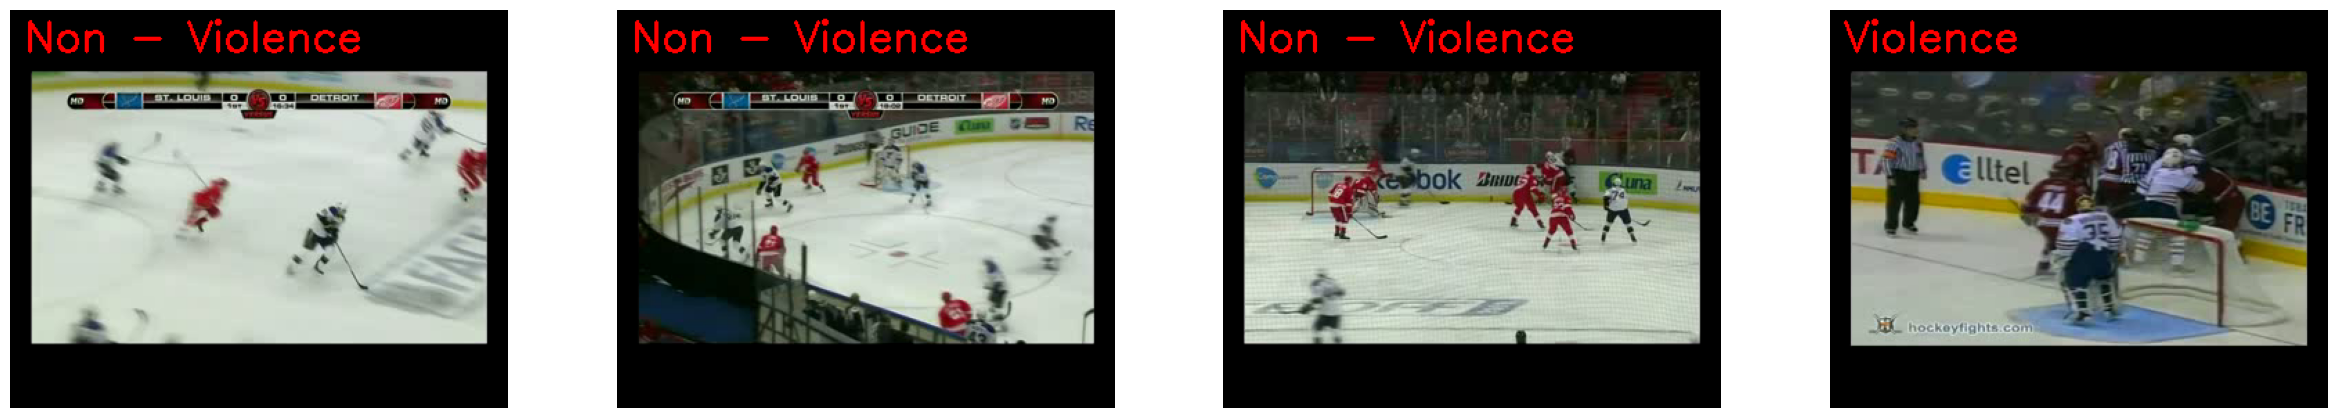

In [3]:
# Create a Matplotlib figure
plt.figure(figsize = (30, 30))
 
# Maintin a list to stores the files which have already been displayed
chosen_files = []

# Displaying 4 random video frames from the hockey fight dataset
for i in range(4):
 
    # Declaring class name
    selected_class_Name = "Non - Violence"
 
    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir("C:\\Users\\shris\\Downloads\\Violence Detection\\data")
 
    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)
    
    # If file has already been chosen, choose another file
    while selected_video_file_name in chosen_files:
        selected_video_file_name = random.choice(video_files_names_list)
        
    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'data/{selected_video_file_name}')
     
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()
 
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()
 
    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Checking if the Video is a Fight/Non-fight Class and adding The Class Name Text on top of the Video Frame.
    if selected_video_file_name[0:2] == "fi":
        selected_class_Name = "Violence"

    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    chosen_files.append(selected_video_file_name)
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, i+1)
    plt.imshow(rgb_frame)
    plt.axis('off')

### Initializing required variables

In [4]:
# Frame size  
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 2

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 24

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".avi"

# Directory
data_dir = "C:\\Users\\shris\\Downloads\\Violence Detection\\data"

### Simple frame extraction

In [5]:
def get_frames(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    
    images = []
    
    vidcap = cv2.VideoCapture(in_file)
    
    success,image = vidcap.read()
        
    count = 0

    while count<20:
                
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
        images.append(res)
    
        success,image = vidcap.read()
    
        count += 1
        
    resul = np.array(images)
    
    resul = (resul / 255.).astype(np.float32)
        
    return resul

### Defining labels for the Violent / Non-Violent Classes

In [6]:
def label_video_names(in_dir):
    
    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []
    
    
    for current_dir, dir_names,file_names in os.walk(in_dir):
        
        for file_name in file_names:
            
            if file_name[0:2] == 'fi':
                labels.append([1,0])
                names.append(file_name)
            elif file_name[0:2] == 'no':
                labels.append([0,1])
                names.append(file_name)
                     
            
    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    shuffle(c)
    
    names, labels = zip(*c)
            
    return names, labels

### Obtaining labels for the whole dataset

In [7]:
# First get the names and labels of the whole videos
names, labels = label_video_names(data_dir)

In [8]:
names[20]

'no464_xvid.avi'

### Frame Extraction

In [14]:
frames = get_frames(data_dir, "fi19_xvid.avi")

In [15]:
visible_frame = (frames*255).astype('uint8')

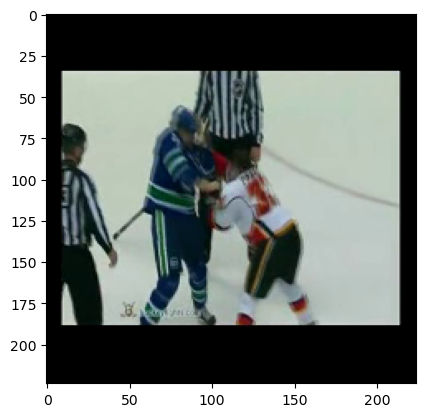

In [22]:
plt.imshow(visible_frame[22])

## OpticalFlow Based Feature Extraction

### Type - I: Frame extraction based on optical flow difference between adjacent frames

In [25]:
def flow_based_frame_extraction(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    
    images = []
    
    vidcap = cv2.VideoCapture(in_file)
    
    success,image = vidcap.read()
        
    count = 0
    
    flow_result = []
    
    flow_frame = np.zeros((224, 224, 3))
    
    mod_frame = np.zeros((224, 224, 3))
    
    mod_frame.fill(255)
    
    while success:
        
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                     interpolation=cv2.INTER_CUBIC)
        images.append(res)
        
        success,image = vidcap.read()
        
        if(count>0):
                
            flow_frame = (images[count] - images[count-1]) % mod_frame
            flow_result.append(flow_frame)
        
    
        count += 1
        
    #resul = np.array(images)
    
    #resul = (resul / 255.).astype(np.float16)
    
    #print(flow_frame)
    
    answer = np.array(flow_result)
    
    answer = (answer / 255.).astype(np.float16)
    
    return answer

--- 0.265838623046875 seconds ---


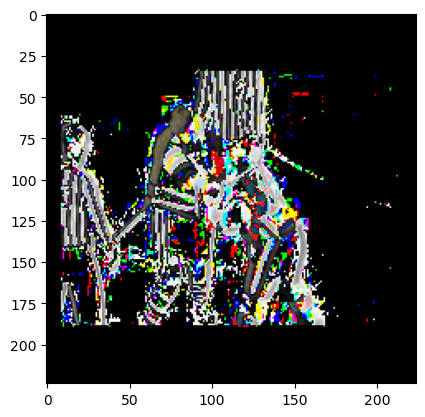

In [27]:
start_time = time.time()
frames = flow_based_frame_extraction(data_dir, "fi19_xvid.avi")
print("--- %s seconds ---" % (time.time() - start_time))
visualize = (frames*255).astype('uint8')
plt.imshow(visualize[22])
# plt.imshow(cv2.cvtColor(visualize[22], cv2.COLOR_BGR2GRAY))

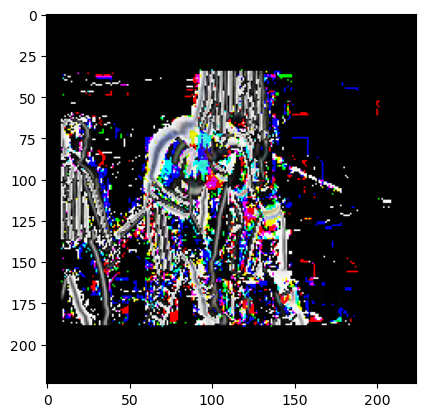

In [31]:
plt.imshow(visualize[15])

In [128]:
# Converting the obtained frames to video for better visualization
fourcc = cv2.VideoWriter_fourcc(*'MP42')
video = cv2.VideoWriter('Basic_flow.mp4', fourcc, float(22), (224,224))
for i in visualize:
    video.write(i)
video.release()

### Refined Flow extraction from Successive frames by thresholding

In [32]:
def threshold_based_frame_extraction(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    
    images = []
    
    vidcap = cv2.VideoCapture(in_file)
    
    success,image = vidcap.read()
        
    count = 0
    
    flow_result = []
    
    flow_frame = np.zeros((224, 224))
    
    mod_frame = np.zeros((224, 224))
    
    mod_frame.fill(255)

    while success:
        
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                     interpolation=cv2.INTER_CUBIC)
        images.append(res)
        
        success,image = vidcap.read()
        
        if(count>0):
                
            diff_frame = cv2.absdiff(images[count], images[count-1])
            res, threshold_frame = cv2.threshold(diff_frame,25,255,cv2.THRESH_BINARY)
            # flow_frame = (flow_frame + (images[count] - images[count-1]) % mod_frame) % mod_frame
            flow_frame = threshold_frame
            flow_result.append(flow_frame)
        
    
        count += 1
        
    #resul = np.array(images)
    
    #resul = (resul / 255.).astype(np.float16)
    
    #print(flow_frame)
    
    answer = np.array(flow_result)
    
    answer = (answer / 255.).astype(np.float16)
    
    return answer

--- 0.05903029441833496 seconds ---


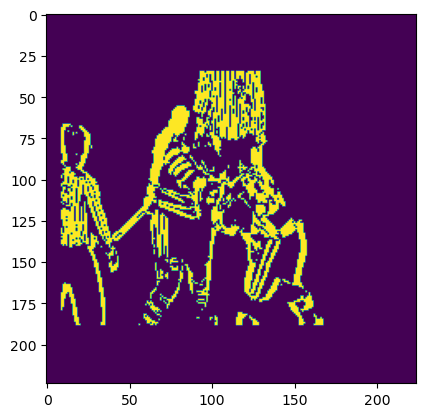

In [34]:
start_time = time.time()
frames = threshold_based_frame_extraction(data_dir, "fi19_xvid.avi")
print("--- %s seconds ---" % (time.time() - start_time))
visualize = (frames*255).astype('uint8')
plt.imshow(visualize[22])

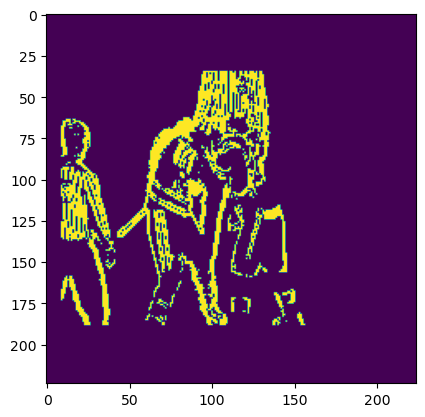

In [38]:
plt.imshow(visualize[15])

In [131]:
fourcc = cv2.VideoWriter_fourcc(*'MP42')
video = cv2.VideoWriter('Refined_flow.mp4', fourcc, float(22), (224,224))
for i in visualize:
    video.write(i)
video.release()

### Flow accumulation 

In [39]:
def threshold_based_flow_accumulation(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    
    images = []
    
    vidcap = cv2.VideoCapture(in_file)
    
    success,image = vidcap.read()
        
    count = 0
    
    flow_result = []
    
    flow_frame = np.zeros((224, 224))
    
    mod_frame = np.zeros((224, 224))
    
    mod_frame.fill(120)

    while count<21:
        
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                     interpolation=cv2.INTER_CUBIC)
        images.append(res)
        
        success,image = vidcap.read()
        
        if(count>0):
                
            diff_frame = cv2.absdiff(images[count], images[count-1])
            res1, threshold_frame1 = cv2.threshold(diff_frame,25,255,cv2.THRESH_BINARY)
            flow_frame = flow_frame + threshold_frame1
            res2, threshold_frame2 = cv2.threshold(flow_frame, 255, 255, cv2.THRESH_TRUNC)
            flow_result.append(threshold_frame2)
            flow_frame = flow_frame%mod_frame
        
    
        count += 1
        
    #resul = np.array(images)
    
    #resul = (resul / 255.).astype(np.float16)
    
    #print(flow_frame)
    
    answer = np.array(flow_result)
    
    answer = (answer / 255.).astype(np.float32)
    
    return answer

--- 0.05160117149353027 seconds ---


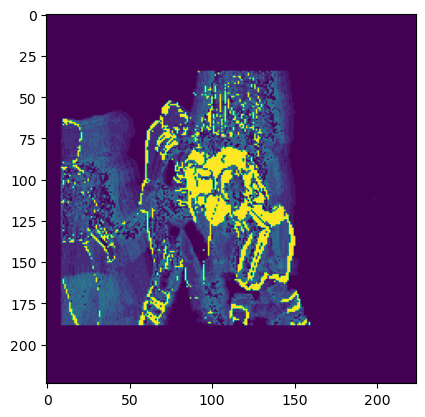

In [40]:
start_time = time.time()
frames = threshold_based_flow_accumulation(data_dir, "fi19_xvid.avi")
print("--- %s seconds ---" % (time.time() - start_time))
visualize = (frames*255).astype('uint8')
plt.imshow(visualize[19])

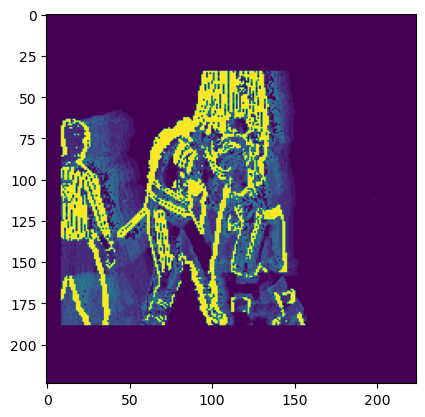

In [14]:
plt.imshow(visualize[15])

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'MP42')
video = cv2.VideoWriter('Flow_accumulation.mp4', fourcc, float(22), (224,224))
for i in visualize:
    video.write(i)
video.release()

### Flow Accumulation Refined

In [54]:
def threshold_based_flow_accumulation(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    
    images = []
    
    vidcap = cv2.VideoCapture(in_file)
    
    success,image = vidcap.read()
        
    count = 0
    
    flow_result = []
    
    flow_frame = np.zeros((224, 224))
    
    mod_frame = np.zeros((224, 224))
    
    mod_frame.fill(1.25)

    while success:
        
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                     interpolation=cv2.INTER_CUBIC)
        images.append(res)
        
        success,image = vidcap.read()
        
        if(count>0):
                
            diff_frame = cv2.absdiff(images[count], images[count-1])
            res1, threshold_frame1 = cv2.threshold(diff_frame,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            flow_frame = flow_frame + threshold_frame1
            res2, threshold_frame2 = cv2.threshold(flow_frame, 255, 255, cv2.THRESH_TRUNC)
            flow_result.append(threshold_frame2)
            flow_frame = threshold_frame2/mod_frame
        
    
        count += 1
        
    #resul = np.array(images)
    
    #resul = (resul / 255.).astype(np.float16)
    
    #print(flow_frame)
    
    answer = np.array(flow_result)
    
    answer = (answer / 255.).astype(np.float16)
    
    return answer

--- 0.057839393615722656 seconds ---


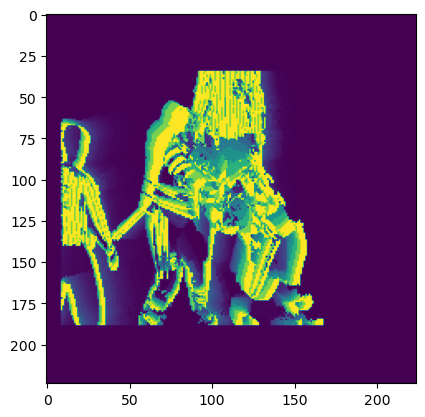

In [55]:
start_time = time.time()
frames = threshold_based_flow_accumulation(data_dir, "fi19_xvid.avi")
print("--- %s seconds ---" % (time.time() - start_time))
visualize = (frames*255).astype('uint8')
plt.imshow(visualize[22])

In [56]:
fourcc = cv2.VideoWriter_fourcc(*'MP42')
video = cv2.VideoWriter('Flow_accumulation2.mp4', fourcc, float(22), (224,224))
for i in visualize:
    video.write(i)
video.release()

### Patch Embedding

In [6]:
PATCH_SIZE = 16
IMAGE_WIDTH = 224
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_CHANNELS = 1
EMBEDDING_DIMS = IMAGE_CHANNELS * PATCH_SIZE**2
NUM_OF_PATCHES = int((IMAGE_WIDTH * IMAGE_HEIGHT) / PATCH_SIZE**2)
BATCH_SIZE = 1

#the image width and image height should be divisible by patch size. This is a check to see that.

assert IMAGE_WIDTH % PATCH_SIZE == 0 and IMAGE_HEIGHT % PATCH_SIZE ==0 , print("Image Width is not divisible by patch size")

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


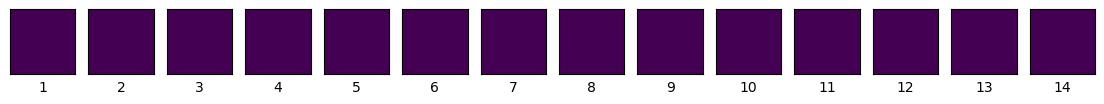

In [8]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1, 
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(visualize[22][:patch_size, patch:patch+patch_size]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


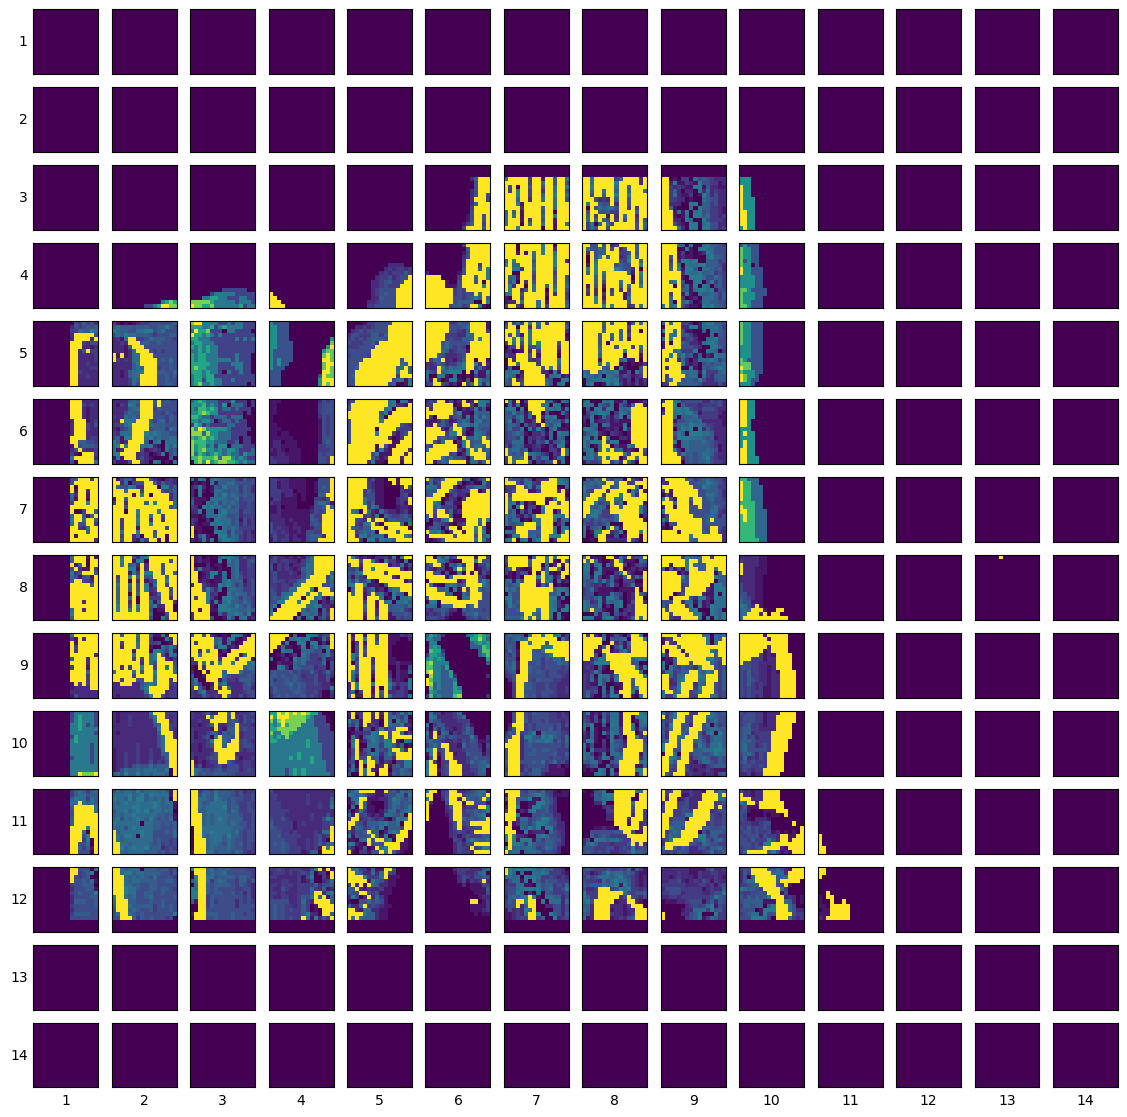

In [10]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size, 
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
        
        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(visualize[22][patch_height:patch_height+patch_size, # iterate through height 
                                        patch_width:patch_width+patch_size]) # iterate through width
        
        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
# fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [8]:
conv_layer = nn.Conv2d(in_channels = IMAGE_CHANNELS, out_channels = EMBEDDING_DIMS, kernel_size = PATCH_SIZE, stride = PATCH_SIZE)

In [7]:
Tensor_Frame = torchvision.transforms.functional.to_tensor(visualize[22])

In [10]:
print(Tensor_Frame)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


In [11]:
image_through_conv = conv_layer(Tensor_Frame.unsqueeze(0))
print(f'Shape of embeddings through the conv layer -> {list(image_through_conv.shape)} <- [batch_size, num_of_patch_rows,num_patch_cols embedding_dims]')

Shape of embeddings through the conv layer -> [1, 256, 14, 14] <- [batch_size, num_of_patch_rows,num_patch_cols embedding_dims]


In [12]:
# Permute the dimensions of image_through_conv to match the expected shape
image_through_conv = image_through_conv.permute((0, 2, 3, 1))

# Create a flatten layer using nn.Flatten
flatten_layer = nn.Flatten(start_dim=1, end_dim=2)

# Pass the image_through_conv through the flatten layer
image_through_conv_and_flatten = flatten_layer(image_through_conv)

# Print the shape of the embedded image
print(f'Shape of embeddings through the flatten layer -> {list(image_through_conv_and_flatten.shape)} <- [batch_size, num_of_patches, embedding_dims]')

# Assign the embedded image to a variable
embedded_image = image_through_conv_and_flatten

Shape of embeddings through the flatten layer -> [1, 196, 256] <- [batch_size, num_of_patches, embedding_dims]


In [13]:
class_token_embeddings = nn.Parameter(torch.rand((1, 1,EMBEDDING_DIMS), requires_grad  = True))
print(f'Shape of class_token_embeddings --> {list(class_token_embeddings.shape)} <-- [batch_size, 1, emdedding_dims]')

embedded_image_with_class_token_embeddings = torch.cat((class_token_embeddings, embedded_image), dim = 1)
print(f'\nShape of image embeddings with class_token_embeddings --> {list(embedded_image_with_class_token_embeddings.shape)} <-- [batch_size, num_of_patches+1, embeddiing_dims]')

position_embeddings = nn.Parameter(torch.rand((1, NUM_OF_PATCHES+1, EMBEDDING_DIMS ), requires_grad = True ))
print(f'\nShape of position_embeddings --> {list(position_embeddings.shape)} <-- [batch_size, num_patches+1, embeddings_dims]')

final_embeddings = embedded_image_with_class_token_embeddings + position_embeddings
print(f'\nShape of final_embeddings --> {list(final_embeddings.shape)} <-- [batch_size, num_patches+1, embeddings_dims]')

Shape of class_token_embeddings --> [1, 1, 256] <-- [batch_size, 1, emdedding_dims]

Shape of image embeddings with class_token_embeddings --> [1, 197, 256] <-- [batch_size, num_of_patches+1, embeddiing_dims]

Shape of position_embeddings --> [1, 197, 256] <-- [batch_size, num_patches+1, embeddings_dims]

Shape of final_embeddings --> [1, 197, 256] <-- [batch_size, num_patches+1, embeddings_dims]


In [18]:
print(final_embeddings)

tensor([[[0.9149, 0.5984, 0.8260,  ..., 1.3420, 1.3736, 0.9748],
         [0.5494, 0.7329, 0.3216,  ..., 0.2344, 0.6262, 0.7561],
         [0.6701, 0.0885, 0.4895,  ..., 0.3794, 0.5894, 0.8500],
         ...,
         [0.1595, 0.0275, 0.3685,  ..., 0.7594, 0.8424, 1.0144],
         [0.5220, 0.4993, 0.9435,  ..., 0.7349, 0.2782, 0.2666],
         [0.6554, 0.2416, 0.8119,  ..., 0.2253, 0.2038, 0.1921]]],
       grad_fn=<AddBackward0>)


In [31]:
class PatchEmbeddingLayer(nn.Module):
    def __init__(self, in_channels, patch_size, embedding_dim,):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.in_channels = in_channels
        self.conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size)
        self.flatten_layer = nn.Flatten(start_dim=1, end_dim=2)
        self.class_token_embeddings = nn.Parameter(torch.rand((BATCH_SIZE, 1, EMBEDDING_DIMS), requires_grad=True))
        self.position_embeddings = nn.Parameter(torch.rand((1, NUM_OF_PATCHES + 1, EMBEDDING_DIMS), requires_grad=True))

    def forward(self, x):
        output = torch.cat((self.class_token_embeddings, self.flatten_layer(self.conv_layer(x).permute((0, 2, 3, 1)))), dim=1) + self.position_embeddings
        return output

In [32]:
patch_embedding_layer = PatchEmbeddingLayer(in_channels=IMAGE_CHANNELS, patch_size=PATCH_SIZE, embedding_dim=IMAGE_CHANNELS * PATCH_SIZE ** 2)

patch_embeddings = patch_embedding_layer(Tensor_Frame)
patch_embeddings.shape

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4

In [10]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size

In [11]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=1,
                 patch_size:int=16,
                 embedding_dim:int=256):
        super().__init__()
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [12]:
# set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=1,
                          patch_size=16,
                          embedding_dim=256)

# Pass a single image through
print(f"Input image shape: {Tensor_Frame.unsqueeze(0).shape}")
patch_embedded_image = patchify(Tensor_Frame.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 1, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 256])


In [13]:
summary(PatchEmbedding(), 
input_size=(1,1,224,224),  
col_names=["input_size", "output_size", "num_params", "trainable"],
col_width=20,
row_settings=["var_names"])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 1, 224, 224]     [1, 196, 256]        --                   True
├─Conv2d (patcher)                       [1, 1, 224, 224]     [1, 256, 14, 14]     65,792               True
├─Flatten (flatten)                      [1, 256, 14, 14]     [1, 256, 196]        --                   --
Total params: 65,792
Trainable params: 65,792
Non-trainable params: 0
Total mult-adds (M): 12.90
Input size (MB): 0.20
Forward/backward pass size (MB): 0.40
Params size (MB): 0.26
Estimated Total Size (MB): 0.87

### Transformer Model for simple frame extraction

In [9]:
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out


class ReAttention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.reattn_weights = nn.Parameter(torch.randn(heads, heads))

        self.reattn_norm = nn.Sequential(
            Rearrange('b h i j -> b i j h'),
            nn.LayerNorm(heads),
            Rearrange('b i j h -> b h i j')
        )

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        # attention

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        attn = dots.softmax(dim=-1)

        # re-attention

        attn = einsum('b h i j, h g -> b g i j', attn, self.reattn_weights)
        attn = self.reattn_norm(attn)

        # aggregate and out

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out
    
class LeFF(nn.Module):
    
    def __init__(self, dim = 192, scale = 4, depth_kernel = 3):
        super().__init__()
        
        scale_dim = dim*scale
        self.up_proj = nn.Sequential(nn.Linear(dim, scale_dim),
                                    Rearrange('b n c -> b c n'),
                                    nn.BatchNorm1d(scale_dim),
                                    nn.GELU(),
                                    Rearrange('b c (h w) -> b c h w', h=14, w=14)
                                    )
        
        self.depth_conv =  nn.Sequential(nn.Conv2d(scale_dim, scale_dim, kernel_size=depth_kernel, padding=1, groups=scale_dim, bias=False),
                          nn.BatchNorm2d(scale_dim),
                          nn.GELU(),
                          Rearrange('b c h w -> b (h w) c', h=14, w=14)
                          )
        
        self.down_proj = nn.Sequential(nn.Linear(scale_dim, dim),
                                    Rearrange('b n c -> b c n'),
                                    nn.BatchNorm1d(dim),
                                    nn.GELU(),
                                    Rearrange('b c n -> b n c')
                                    )
        
    def forward(self, x):
        x = self.up_proj(x)
        x = self.depth_conv(x)
        x = self.down_proj(x)
        return x
    
    
class LCAttention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)
        q = q[:, :, -1, :].unsqueeze(2) # Only Lth element use as query

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

In [15]:
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import numpy as np

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.norm = nn.LayerNorm(dim)
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)


  
class ViViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, num_frames, dim = 192, depth = 4, heads = 3, pool = 'cls', in_channels = 3, dim_head = 64, dropout = 0.,
                 emb_dropout = 0., scale_dim = 4, ):
        super().__init__()
        
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'


        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = in_channels * patch_size ** 2
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b t c (h p1) (w p2) -> b t (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_frames, num_patches + 1, dim))
        self.space_token = nn.Parameter(torch.randn(1, 1, dim))
        self.space_transformer = Transformer(dim, depth, heads, dim_head, dim*scale_dim, dropout)

        self.temporal_token = nn.Parameter(torch.randn(1, 1, dim))
        self.temporal_transformer = Transformer(dim, depth, heads, dim_head, dim*scale_dim, dropout)

        self.dropout = nn.Dropout(emb_dropout)
        self.pool = pool

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )
        


    def forward(self, x):
        x = self.to_patch_embedding(x)
        b, t, n, _ = x.shape

        cls_space_tokens = repeat(self.space_token, '() n d -> b t n d', b = b, t=t)
        x = torch.cat((cls_space_tokens, x), dim=2)
        x += self.pos_embedding[:, :, :(n + 1)]
        x = self.dropout(x)

        x = rearrange(x, 'b t n d -> (b t) n d')
        x = self.space_transformer(x)
        x = rearrange(x[:, 0], '(b t) ... -> b t ...', b=b)

        cls_temporal_tokens = repeat(self.temporal_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_temporal_tokens, x), dim=1)

        x = self.temporal_transformer(x)
        

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.mlp_head(x)
        
        return torch.round(torch.sigmoid(x))


In [16]:
img = torch.ones([1, 20, 3, 224, 224])
model = ViViT(224, 16, 2, 20)
parameters = filter(lambda p: p.requires_grad, model.parameters())
parameters = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
print('Trainable Parameters: %.3fM' % parameters)
    
out = model(img)
    
print("Shape of out :", out.shape) 

Trainable Parameters: 4.460M
Shape of out : torch.Size([1, 2])


In [17]:
out

tensor([[0., 0.]], grad_fn=<RoundBackward0>)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(names, labels, test_size=0.2, random_state=42)


### Model Training and Testing for simple frame extraction

In [17]:
X_train_tensor = torch.empty((0), dtype=torch.float32)
i = 0
l = []
for data in X_train:
    res = get_frames(data_dir, data)
    x = np.array(res).transpose(0, 3, 1, 2)
    l.append(x)
    i+=1

X_train_tensor = torch.tensor(l)
    

C:\Users\shris\AppData\Local\Temp\ipykernel_27800\2693880971.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  X_train_tensor = torch.tensor(l)


In [18]:
len(l)

800

In [19]:
X_test_tensor = torch.empty((0), dtype=torch.float32)
i = 0
l = []
for data in X_test:
    res = get_frames(data_dir, data)
    x = np.array(res).transpose(0, 3, 1, 2)
    l.append(x)
    i+=1

X_test_tensor = torch.tensor(l)

In [20]:
X_train_tensor.size()

torch.Size([800, 20, 3, 224, 224])

In [21]:
Y_train_labels = y_train
Y_train_labels = torch.tensor(Y_train_labels, dtype=torch.float32)
Y_test_labels = y_test
Y_test_labels = torch.tensor(Y_test_labels, dtype=torch.float32)

In [24]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

torch.manual_seed(42)

# Set the number of epochs
epochs = 5

# Put data to target device
# X_train, y_train = X_train.to(device), y_train.to(device)
# X_test, y_test = X_test.to(device), y_test.to(device)

loss_fn = nn.BCELoss() # BCEWithLogitsLoss = sigmoid built-in
model = ViViT(224, 16, 2, 20)

# Create an optimizer
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=3e-3,
                             betas=(0.9, 0.999), 
                             weight_decay=0.3) 

batch_size = 50
batches_per_epoch = 16
test_batches_per_epoch = 4
# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    y_train_tensor = torch.empty((0), dtype=torch.float32)
    for i in range(batches_per_epoch):
        start = i * batch_size
        Xbatch = X_train_tensor[start:start+batch_size]
        Ybatch = Y_train_labels[start:start+batch_size]
        model.train()

        # 1. Forward pass (model outputs raw logits)
        y_logits = model(Xbatch).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 


        # 2. Calculate loss/accuracy
        # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
        #                y_train) 
        loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                       Ybatch) 
        #acc = accuracy_fn(y_true=Ybatch, 
        #                  y_pred=y_logits) 
        y_train_tensor = torch.cat((y_train_tensor, y_logits), 0)
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backwards
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        ### Testing
    
    train_acc = accuracy_fn(y_true=Y_train_labels, 
                          y_pred=y_train_tensor)
    train_loss = loss_fn(y_train_tensor, Y_train_labels)
    
    model.eval()
    
    with torch.inference_mode():
        y_test_tensor = torch.empty((0), dtype=torch.float32)
        
        for i in range(test_batches_per_epoch):
            
            start = i * batch_size
            Xbatch = X_test_tensor[start:start+batch_size]
            Ybatch = Y_test_labels[start:start+batch_size]
            # 1. Forward pass
            test_logits = model(Xbatch).squeeze() 
              # test_pred = torch.round(torch.sigmoid(test_logits))
            y_test_tensor = torch.cat((y_test_tensor, test_logits), 0)
        # 2. Caculate loss/accuracy
        
        test_loss = loss_fn(y_test_tensor,
                            Y_test_labels)
        test_acc = accuracy_fn(y_true=Y_test_labels,
                                y_pred=y_test_tensor)

    
    print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 48.50000, Accuracy: 103.00% | Test Loss: 50.00000, Test Accuracy: 100.00%
Epoch: 1 | Loss: 51.62500, Accuracy: 96.75% | Test Loss: 44.00000, Test Accuracy: 112.00%
Epoch: 2 | Loss: 50.12500, Accuracy: 99.75% | Test Loss: 56.00000, Test Accuracy: 88.00%
Epoch: 3 | Loss: 51.50000, Accuracy: 97.00% | Test Loss: 44.00000, Test Accuracy: 112.00%
Epoch: 4 | Loss: 51.50000, Accuracy: 97.00% | Test Loss: 44.00000, Test Accuracy: 112.00%


### Transformer Model for Flow accumulated frames

In [22]:
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out


class ReAttention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.reattn_weights = nn.Parameter(torch.randn(heads, heads))

        self.reattn_norm = nn.Sequential(
            Rearrange('b h i j -> b i j h'),
            nn.LayerNorm(heads),
            Rearrange('b i j h -> b h i j')
        )

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        # attention

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        attn = dots.softmax(dim=-1)

        # re-attention

        attn = einsum('b h i j, h g -> b g i j', attn, self.reattn_weights)
        attn = self.reattn_norm(attn)

        # aggregate and out

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out
    
class LeFF(nn.Module):
    
    def __init__(self, dim = 192, scale = 4, depth_kernel = 3):
        super().__init__()
        
        scale_dim = dim*scale
        self.up_proj = nn.Sequential(nn.Linear(dim, scale_dim),
                                    Rearrange('b n c -> b c n'),
                                    nn.BatchNorm1d(scale_dim),
                                    nn.GELU(),
                                    Rearrange('b c (h w) -> b c h w', h=14, w=14)
                                    )
        
        self.depth_conv =  nn.Sequential(nn.Conv2d(scale_dim, scale_dim, kernel_size=depth_kernel, padding=1, groups=scale_dim, bias=False),
                          nn.BatchNorm2d(scale_dim),
                          nn.GELU(),
                          Rearrange('b c h w -> b (h w) c', h=14, w=14)
                          )
        
        self.down_proj = nn.Sequential(nn.Linear(scale_dim, dim),
                                    Rearrange('b n c -> b c n'),
                                    nn.BatchNorm1d(dim),
                                    nn.GELU(),
                                    Rearrange('b c n -> b n c')
                                    )
        
    def forward(self, x):
        x = self.up_proj(x)
        x = self.depth_conv(x)
        x = self.down_proj(x)
        return x
    
    
class LCAttention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)
        q = q[:, :, -1, :].unsqueeze(2) # Only Lth element use as query

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

In [23]:
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import numpy as np

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.norm = nn.LayerNorm(dim)
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)


  
class ViViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, num_frames, dim = 192, depth = 4, heads = 3, pool = 'cls', in_channels = 1, dim_head = 64, dropout = 0.,
                 emb_dropout = 0., scale_dim = 4, ):
        super().__init__()
        
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'


        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = in_channels * patch_size ** 2
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b t c (h p1) (w p2) -> b t (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_frames, num_patches + 1, dim))
        self.space_token = nn.Parameter(torch.randn(1, 1, dim))
        self.space_transformer = Transformer(dim, depth, heads, dim_head, dim*scale_dim, dropout)

        self.temporal_token = nn.Parameter(torch.randn(1, 1, dim))
        self.temporal_transformer = Transformer(dim, depth, heads, dim_head, dim*scale_dim, dropout)

        self.dropout = nn.Dropout(emb_dropout)
        self.pool = pool

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )
        


    def forward(self, x):
        x = self.to_patch_embedding(x)
        b, t, n, _ = x.shape

        cls_space_tokens = repeat(self.space_token, '() n d -> b t n d', b = b, t=t)
        x = torch.cat((cls_space_tokens, x), dim=2)
        x += self.pos_embedding[:, :, :(n + 1)]
        x = self.dropout(x)

        x = rearrange(x, 'b t n d -> (b t) n d')
        x = self.space_transformer(x)
        x = rearrange(x[:, 0], '(b t) ... -> b t ...', b=b)

        cls_temporal_tokens = repeat(self.temporal_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_temporal_tokens, x), dim=1)

        x = self.temporal_transformer(x)
        

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.mlp_head(x)
        
        return torch.round(torch.sigmoid(x))


In [54]:
img = torch.ones([1, 20, 1, 224, 224])
model = ViViT(224, 16, 2, 20)
parameters = filter(lambda p: p.requires_grad, model.parameters())
parameters = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
print('Trainable Parameters: %.3fM' % parameters)
    
out = model(img)
    
print("Shape of out :", out.shape) 

Trainable Parameters: 4.362M
Shape of out : torch.Size([1, 2])


In [55]:
out

tensor([[0., 0.]], grad_fn=<RoundBackward0>)

### Model training and testing for flow accumulated frames

In [41]:
X_train_tensor = torch.empty((0), dtype=torch.float32)
i = 0
l = []

for data in X_train:
    res = threshold_based_flow_accumulation(data_dir, data)
    k=[]
    k.append(res)
    x = np.array(k).transpose(1, 0, 2, 3)
    l.append(x)
    i+=1

X_train_tensor = torch.tensor(l)
print(len(l))

800


In [42]:
print(X_train_tensor.size())

torch.Size([800, 20, 1, 224, 224])


In [43]:
X_test_tensor = torch.empty((0), dtype=torch.float32)
i = 0
l = []
for data in X_test:
    res = threshold_based_flow_accumulation(data_dir, data)
    k=[]
    k.append(res)
    x = np.array(k).transpose(1, 0, 2, 3)
    l.append(x)
    i+=1

X_test_tensor = torch.tensor(l)
print(X_test_tensor.size())

torch.Size([200, 20, 1, 224, 224])


In [44]:
Y_train_labels = y_train
Y_train_labels = torch.tensor(Y_train_labels, dtype=torch.float32)
Y_test_labels = y_test
Y_test_labels = torch.tensor(Y_test_labels, dtype=torch.float32)

In [45]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

torch.manual_seed(42)

# Set the number of epochs
epochs = 5

# Put data to target device
# X_train, y_train = X_train.to(device), y_train.to(device)
# X_test, y_test = X_test.to(device), y_test.to(device)

loss_fn = nn.BCELoss() # BCEWithLogitsLoss = sigmoid built-in
model = ViViT(224, 16, 2, 20)

# Create an optimizer
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=3e-3,
                             betas=(0.9, 0.999), 
                             weight_decay=0.3) 

batch_size = 50
batches_per_epoch = 16
test_batches_per_epoch = 4
# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    y_train_tensor = torch.empty((0), dtype=torch.float32)
    for i in range(batches_per_epoch):
        start = i * batch_size
        Xbatch = X_train_tensor[start:start+batch_size]
        Ybatch = Y_train_labels[start:start+batch_size]
        model.train()

        # 1. Forward pass (model outputs raw logits)
        y_logits = model(Xbatch).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 


        # 2. Calculate loss/accuracy
        # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
        #                y_train) 
        loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                       Ybatch) 
        #acc = accuracy_fn(y_true=Ybatch, 
        #                  y_pred=y_logits) 
        y_train_tensor = torch.cat((y_train_tensor, y_logits), 0)
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backwards
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        ### Testing
    
    train_acc = accuracy_fn(y_true=Y_train_labels, 
                          y_pred=y_train_tensor)
    train_loss = loss_fn(y_train_tensor, Y_train_labels)
    
    model.eval()
    
    with torch.inference_mode():
        y_test_tensor = torch.empty((0), dtype=torch.float32)
        
        for i in range(test_batches_per_epoch):
            
            start = i * batch_size
            Xbatch = X_test_tensor[start:start+batch_size]
            Ybatch = Y_test_labels[start:start+batch_size]
            # 1. Forward pass
            test_logits = model(Xbatch).squeeze() 
              # test_pred = torch.round(torch.sigmoid(test_logits))
            y_test_tensor = torch.cat((y_test_tensor, test_logits), 0)
        # 2. Caculate loss/accuracy
        
        test_loss = loss_fn(y_test_tensor,
                            Y_test_labels)
        test_acc = accuracy_fn(y_true=Y_test_labels,
                                y_pred=y_test_tensor)

    
    print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 48.62500, Accuracy: 102.75% | Test Loss: 50.00000, Test Accuracy: 100.00%
Epoch: 1 | Loss: 50.25000, Accuracy: 99.50% | Test Loss: 44.00000, Test Accuracy: 112.00%
Epoch: 2 | Loss: 51.25000, Accuracy: 97.50% | Test Loss: 50.00000, Test Accuracy: 100.00%
Epoch: 3 | Loss: 50.00000, Accuracy: 100.00% | Test Loss: 50.00000, Test Accuracy: 100.00%
Epoch: 4 | Loss: 49.50000, Accuracy: 101.00% | Test Loss: 50.00000, Test Accuracy: 100.00%


In [56]:
l = []
res = threshold_based_flow_accumulation(data_dir, "no9_xvid.avi")
k=[]
k.append(res)
x = np.array(k).transpose(1, 0, 2, 3)
l.append(x)
demo = torch.tensor(l)
print(demo.size())

torch.Size([1, 20, 1, 224, 224])


In [57]:
print(model(demo))

tensor([[0., 0.]], grad_fn=<RoundBackward0>)


In [52]:
Y_test_labels

tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1

In [53]:
y_test_tensor

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1